<a href="https://colab.research.google.com/github/azhare88/Customer-Churn-Metrics/blob/main/ustomer_churn_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Calculate Customer Churn Metrics**
Customer churn metrics adalah serangkaian metrik yang digunakan untuk mengukur dan menganalisis tingkat churn, yaitu jumlah pelanggan yang meninggalkan atau berhenti menggunakan layanan atau produk dalam jangka waktu tertentu. Memahami dan mengukur churn penting untuk menjaga pertumbuhan bisnis, karena pelanggan yang setia lebih murah dipertahankan daripada mendapatkan pelanggan baru.

In [ ]:
# Import packages
import numpy as np
import pandas as pd
import plotly.express as px

# Set the path to your file
path = "/content/drive/MyDrive/Colab Notebooks/Fille/payments.csv"

# Set your date column
date_col = "payment_date"

# Import churn data
payments = pd.read_csv(path, parse_dates=[date_col])

# Categorize payment periods (optional)
payments["payment_period"] = pd.to_datetime(payments[date_col]) + pd.offsets.MonthBegin(-1)

# Preview the data
payments

# **Net retention rate**
Rasio retensi bersih adalah persentase pendapatan berulang yang berasal dari pelanggan yang berlangganan di awal periode.

  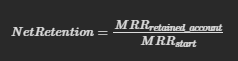

Perlu dicatat bahwa perhitungan ini tidak mencakup pendapatan dari pelanggan baru. Perhitungan ini mencakup dampak churn, upsell (misalnya, pelanggan yang meningkatkan langganan mereka), dan downsell (misalnya, pelanggan yang mengurangi tingkat langganan mereka). Karena perhitungan ini mencakup upsell, rasio retensi bersih adalah ukuran churn yang kurang spesifik dibandingkan ukuran lainnya.

In [ ]:
# Define a function to calculate the net retention rate
def nrr(x, dataframe):
    # Identify current and previous period based on group
    current_period = x["payment_period"].max()
    previous_period = current_period - pd.DateOffset(months=1)
    # Calculate the previous period's recurring revenue
    previous_period_rr = dataframe[dataframe["payment_period"] == previous_period]["price"].sum()
    # Identify the users in the previous period
    previous_period_users = dataframe[dataframe["payment_period"] == previous_period]["userid"].unique()
    # Calculate the current period's recurring revenue that comes from the previous periods's users
    current_period_retained_rr = dataframe[
        (dataframe["userid"].isin(previous_period_users))
        & (dataframe["payment_period"] == current_period)
    ]["price"].sum()
    # Caculate and return the net retention rate
    try:
        nrr = current_period_retained_rr / previous_period_rr
        return nrr
    except:
        return None


# Group the data by payment period and calculate the net retention rate
nrr_data = (
    payments.groupby("payment_period")
    .apply(nrr, dataframe=payments)
    .reset_index(name="nrr")
)

# Review the data
nrr_data

In [ ]:
fig = px.line(
    nrr_data,
    x="payment_period",
    y="nrr",
    title="Net Retention Rate by Period"
)

fig.show()

# **Standard account churn**
Churn akun standar adalah proporsi pelanggan yang membatalkan langganan terhadap jumlah total pelanggan di awal periode. Pelanggan hanya dianggap churn jika mereka membatalkan semua langganan, dan oleh karena itu penjualan turun atau pengurangan jumlah langganan yang dimiliki pelanggan tidak dianggap sebagai churn.

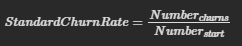

In [ ]:
# Define a function to calculate the standard account churn
def std_churn(x, dataframe):
    # Identify current and previous period based on group
    current_period = x["payment_period"].max()
    previous_period = current_period - pd.DateOffset(months=1)
    # Calculate the previous period's total number of users
    previous_period_user_count = dataframe[
        dataframe["payment_period"] == previous_period
    ]["userid"].nunique()
    # Identify the users in the previous and current periods
    previous_period_users = dataframe[dataframe["payment_period"] == previous_period]["userid"].unique()
    current_period_users = dataframe[dataframe["payment_period"] == current_period]["userid"].unique()
    # Calculate the number of churned users
    churns = len(np.setdiff1d(previous_period_users, current_period_users))
    # Caculate and return the standard churn
    try:
        std_churn = churns / previous_period_user_count
        return std_churn
    except:
        return None


# Group the data by payment period and calculate the net retention rate
std_churn_data = (
    payments.groupby("payment_period")
    .apply(std_churn, dataframe=payments)
    .reset_index(name="std_churn")
)

# Review the data
std_churn_data

In [ ]:
fig = px.line(
    std_churn_data,
    x="payment_period",
    y="std_churn",
    title="Standard Account Churn by Period",
)

fig.show()

# **Monthly recurring revenue churn**
Menghitung perputaran pendapatan berulang bulanan
Metrik perputaran terakhir yang perlu dicakup adalah "pendapatan berulang bulanan", varian dari rasio retensi bersih. Sementara rasio retensi bersih mencakup penjualan tambahan, pendapatan berulang bulanan tidak, karena secara teknis, hal ini tidak termasuk perputaran.

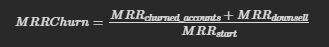

Perputaran pendapatan berulang bulanan adalah metrik yang berguna jika Anda memiliki berbagai harga yang berbeda (misalnya, tingkatan harga yang berbeda). Ini dianggap sebagai definisi perputaran yang lebih akurat karena berfokus secara eksklusif pada penjualan yang lebih rendah dan total perputaran.

In [ ]:
# Define a function to calculate the periodly recurring revenue churn
def mrr(x, dataframe):
    # Identify current and previous period based on group
    current_period = x["payment_period"].max()
    previous_period = current_period - pd.DateOffset(months=1)
    # Identify total recurring revenue from previous period
    previous_period_rr = dataframe[dataframe["payment_period"] == previous_period]["price"].sum()
    # Identify the users in the previous and current periods
    previous_period_users = dataframe[dataframe["payment_period"] == previous_period]["userid"].unique()
    current_period_users = dataframe[dataframe["payment_period"] == current_period]["userid"].unique()
    # Identify retained and churned users
    retained_users = np.intersect1d(previous_period_users, current_period_users)
    churned_users = np.setdiff1d(previous_period_users, current_period_users)
    # Identify revenue of retained users in each period
    current_period_retained_rr = dataframe[
        (dataframe["userid"].isin(retained_users))
        & (dataframe["payment_period"] == current_period)
    ]["price"].values
    previous_period_retained_rr = dataframe[
        (dataframe["userid"].isin(retained_users))
        & (dataframe["payment_period"] == previous_period)
    ]["price"].values
    # Define mask to filter arrays for downsells
    downsells = previous_period_retained_rr > current_period_retained_rr
    # Calculate total downsell loss
    downsell_loss = np.sum(
        previous_period_retained_rr[downsells] - current_period_retained_rr[downsells]
    )
    # Calculate loss to users who churned
    churn_loss = dataframe[
        (dataframe["userid"].isin(churned_users))
        & (dataframe["payment_period"] == previous_period)
    ]["price"].sum()
    # Caculate and return the monthly recurring revenue
    try:
        mrr = (downsell_loss + churn_loss) / previous_period_rr
        return mrr
    except:
        return None


# Group the data by payment period and calculate the monthly recurring revenue churn
mrr_data = (
    payments.groupby("payment_period")
    .apply(mrr, dataframe=payments)
    .reset_index(name="mrr")
)

# Review the data
mrr_data

In [ ]:
fig = px.line(
    mrr_data,
    x="payment_period",
    y="mrr",
    title="Recurring Revenue Churn by Period"
)

fig.show()